# 1.7d: Cluster Tokens in Context

This notebook visualizes cluster tokens within the full vocabulary logit distribution.

## The Question

In 1.7c, we saw that cluster tokens have zero logit variation (flat line) while normal tokens show smooth S-curve variation. But where do those 2,212 cluster tokens fall within the overall distribution?

**This visualization shows both populations together:**
- Non-cluster tokens in blue (normal vocabulary behavior)
- Cluster tokens in red (degenerate flat band)

By zooming into different regions of the ranking, we can see:
- Whether the cluster falls in a steep or shallow part of the curve
- How visible the flat band is against the surrounding slope
- The relative position of degenerate tokens in the logit hierarchy

## Method

1. Load W in bfloat16 and compute logits = W @ PC1
2. Sort all tokens by logit (descending)
3. Track which tokens are cluster vs non-cluster
4. Plot with different colors for each population
5. Allow x-axis zoom to examine different regions

## Parameters

In [11]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# X-axis limits (token rank)
X_MIN = 0
X_MAX = 151936

# Colors
NON_CLUSTER_COLOR = 'steelblue'
CLUSTER_COLOR = 'red'
NON_CLUSTER_ALPHA = 0.6
CLUSTER_ALPHA = 0.8

# Point size
NON_CLUSTER_SIZE = 1.0
CLUSTER_SIZE = 2.0

# Visualization
FIGSIZE = (16, 8)
DPI = 150

## Imports

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [13]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Unembedding Matrix (bfloat16)

In [14]:
# Load W in bfloat16
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W = load_file(tensor_path)["W"].to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")
print(f"  dtype: {W.dtype}")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions
  dtype: torch.bfloat16


## Load Cluster Reference Frame (PC1)

In [15]:
# Load precomputed PCA from 1.6a
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
eigenvectors = ref_data['W_eigenvectors'].to(device)

# Extract PC1 and convert to bfloat16
pc1 = eigenvectors[:, 0].to(W.dtype)

print(f"\nLoaded cluster reference frame")
print(f"  PC1 shape: {pc1.shape}")
print(f"  PC1 dtype: {pc1.dtype}")


Loaded cluster reference frame
  PC1 shape: torch.Size([2560])
  PC1 dtype: torch.bfloat16


## Load Cluster Tokens

In [16]:
# Load cluster tokens from 1.4h
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4h_cluster_tokens.safetensors")
cluster_data = load_file(cluster_path)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

# Create set for fast membership checking
cluster_token_set = set(cluster_token_ids.cpu().numpy())

print(f"\nLoaded {len(cluster_token_ids):,} cluster token IDs")


Loaded 2,212 cluster token IDs


## Compute Logits

In [17]:
print(f"\n{'='*70}")
print("COMPUTING LOGITS")
print(f"{'='*70}\n")

# Compute logits = W @ PC1
logits = W @ pc1
logits_f32 = logits.float()

print(f"✓ Logits computed: {logits.shape}")
print(f"  dtype: {logits.dtype}")

# Statistics
print(f"\nLogit distribution:")
print(f"  Max: {logits_f32.max().item():.6f}")
print(f"  Min: {logits_f32.min().item():.6f}")
print(f"  Range: {(logits_f32.max() - logits_f32.min()).item():.6f}")


COMPUTING LOGITS

✓ Logits computed: torch.Size([151936])
  dtype: torch.bfloat16

Logit distribution:
  Max: 0.726562
  Min: -0.804688
  Range: 1.531250


## Sort and Separate Populations

In [18]:
print(f"\n{'='*70}")
print("SORTING AND SEPARATING POPULATIONS")
print(f"{'='*70}\n")

# Sort logits (descending) and get token indices
sorted_logits, sorted_indices = torch.sort(logits_f32, descending=True)
sorted_logits_np = sorted_logits.cpu().numpy()
sorted_indices_np = sorted_indices.cpu().numpy()

# Determine which sorted tokens are in cluster
is_cluster = np.array([idx in cluster_token_set for idx in sorted_indices_np])

# Separate into cluster and non-cluster
cluster_ranks = np.where(is_cluster)[0]
non_cluster_ranks = np.where(~is_cluster)[0]

cluster_logits_sorted = sorted_logits_np[cluster_ranks]
non_cluster_logits_sorted = sorted_logits_np[non_cluster_ranks]

print(f"Sorted all {N:,} tokens by logit")
print(f"\nCluster tokens:")
print(f"  Count: {len(cluster_ranks):,}")
print(f"  Rank range: [{cluster_ranks.min()}, {cluster_ranks.max()}]")
print(f"  Logit range: [{cluster_logits_sorted.min():.6f}, {cluster_logits_sorted.max():.6f}]")
print(f"\nNon-cluster tokens:")
print(f"  Count: {len(non_cluster_ranks):,}")


SORTING AND SEPARATING POPULATIONS

Sorted all 151,936 tokens by logit

Cluster tokens:
  Count: 2,212
  Rank range: [50729, 54521]
  Logit range: [0.308594, 0.308594]

Non-cluster tokens:
  Count: 149,724


## Visualization: Cluster in Context


Creating visualization...

X-axis range: [0, 151,936]
Tokens in visible range:
  Non-cluster: 149,724
  Cluster: 2,212


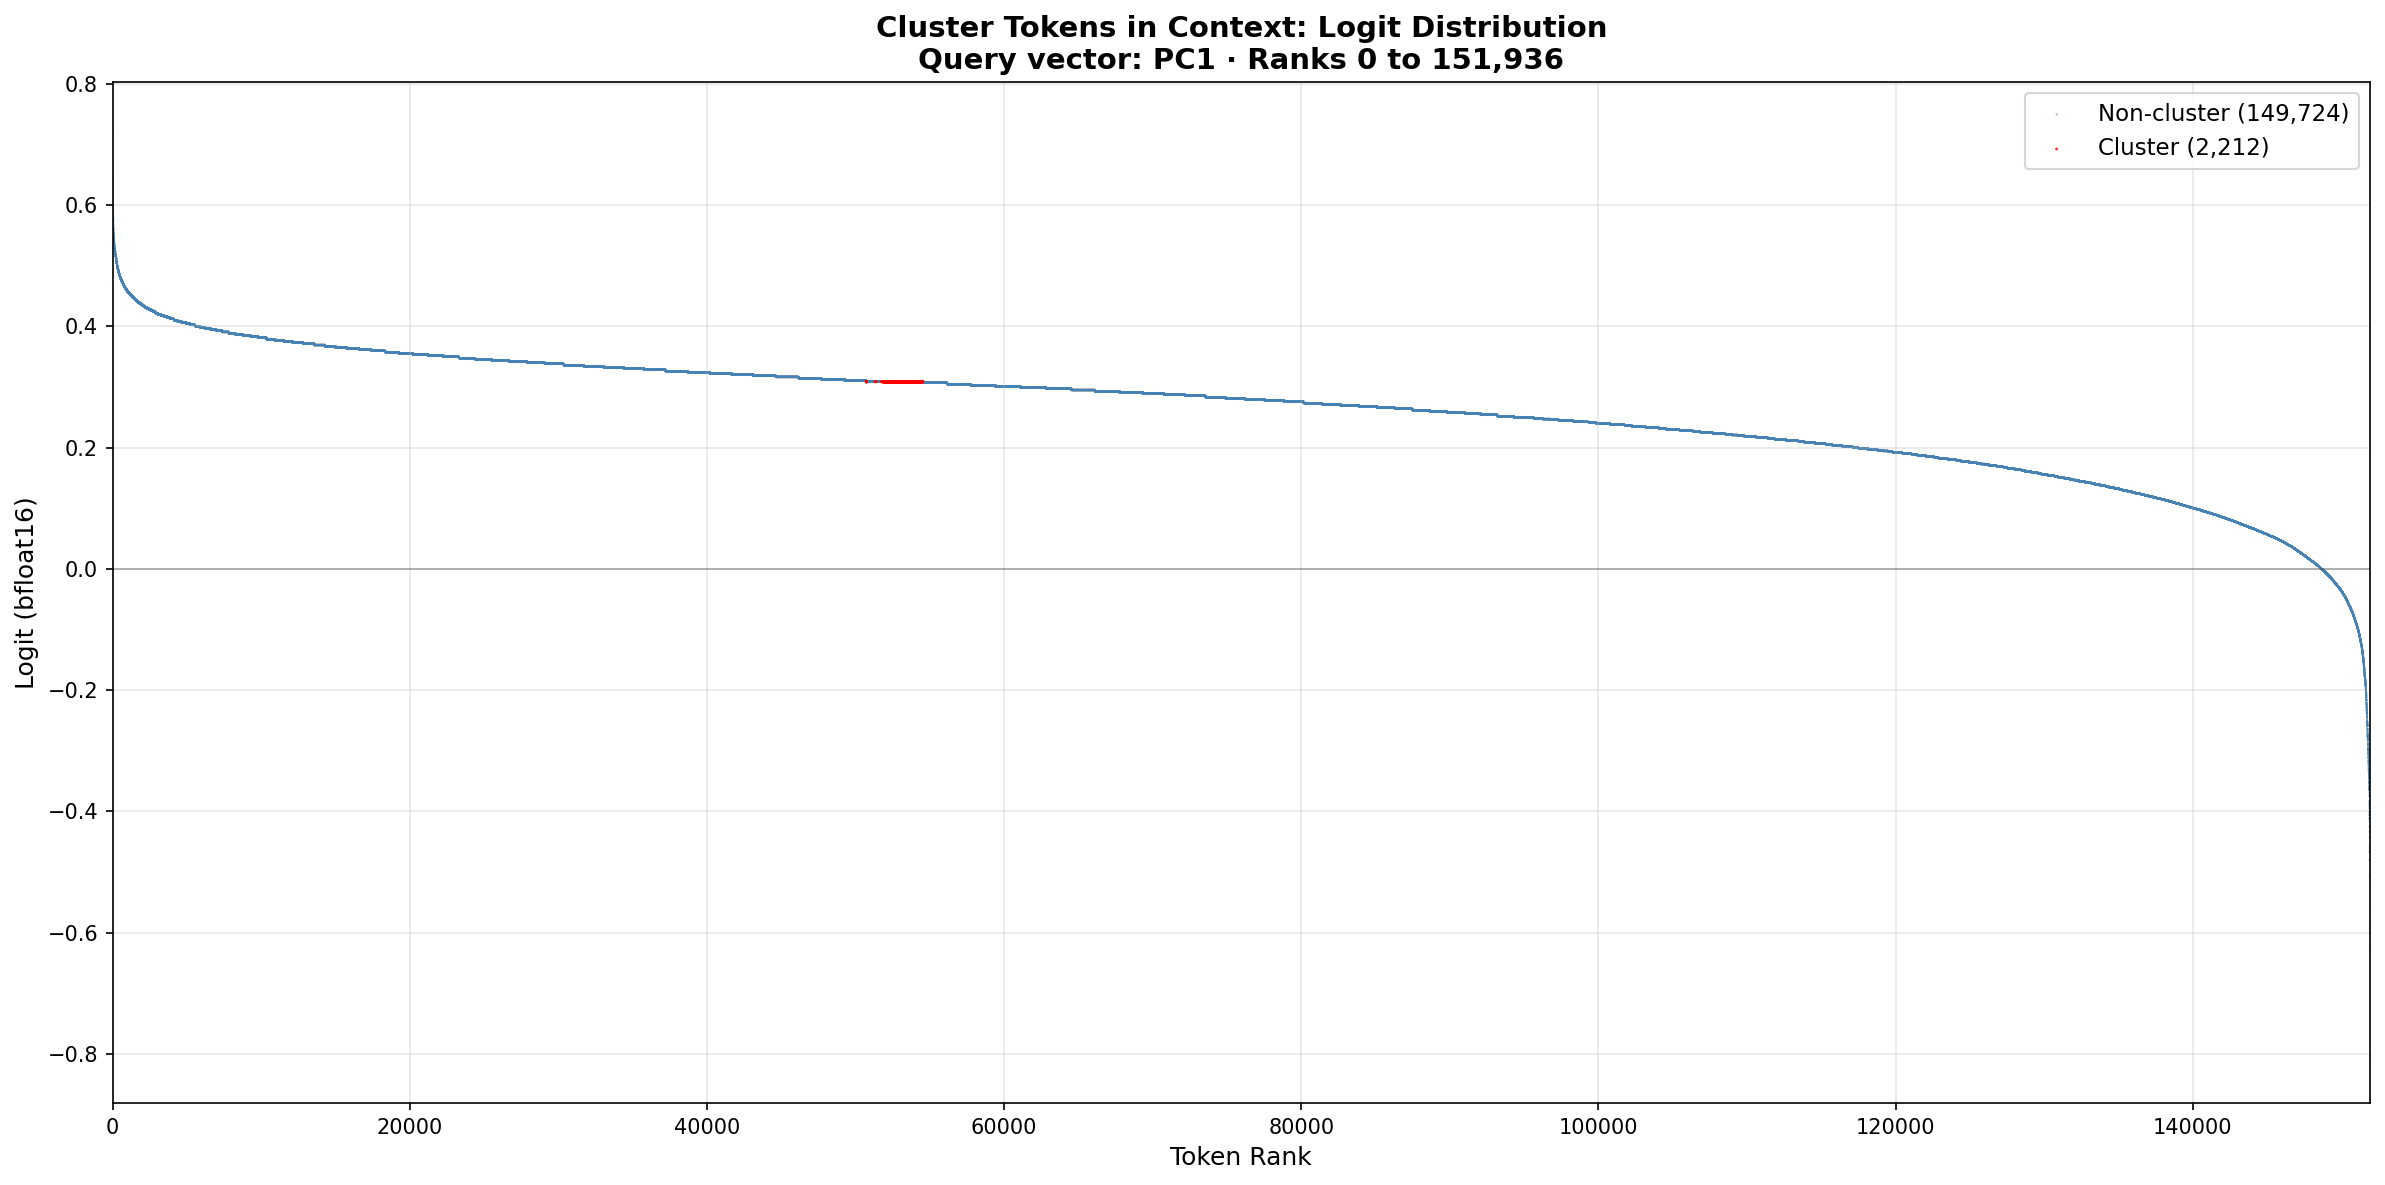


✓ Visualization complete


In [19]:
print(f"\nCreating visualization...\n")
print(f"X-axis range: [{X_MIN:,}, {X_MAX:,}]")

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Filter to x-axis range for plotting
non_cluster_mask = (non_cluster_ranks >= X_MIN) & (non_cluster_ranks < X_MAX)
cluster_mask = (cluster_ranks >= X_MIN) & (cluster_ranks < X_MAX)

n_non_cluster_visible = non_cluster_mask.sum()
n_cluster_visible = cluster_mask.sum()

print(f"Tokens in visible range:")
print(f"  Non-cluster: {n_non_cluster_visible:,}")
print(f"  Cluster: {n_cluster_visible:,}")

# Plot non-cluster tokens (background)
ax.scatter(non_cluster_ranks[non_cluster_mask], 
           non_cluster_logits_sorted[non_cluster_mask],
           s=NON_CLUSTER_SIZE, 
           alpha=NON_CLUSTER_ALPHA,
           color=NON_CLUSTER_COLOR,
           label=f'Non-cluster ({len(non_cluster_ranks):,})',
           edgecolors='none',
           rasterized=True)

# Plot cluster tokens (foreground)
ax.scatter(cluster_ranks[cluster_mask], 
           cluster_logits_sorted[cluster_mask],
           s=CLUSTER_SIZE, 
           alpha=CLUSTER_ALPHA,
           color=CLUSTER_COLOR,
           label=f'Cluster ({len(cluster_ranks):,})',
           edgecolors='none',
           rasterized=True)

# Formatting
ax.set_xlabel('Token Rank', fontsize=12)
ax.set_ylabel('Logit (bfloat16)', fontsize=12)
ax.set_title(f'Cluster Tokens in Context: Logit Distribution\n' +
             f'Query vector: PC1 · Ranks {X_MIN:,} to {X_MAX:,}',
             fontsize=14, fontweight='bold')
ax.set_xlim(X_MIN, X_MAX)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
ax.legend(loc='best', fontsize=11)

# ax.set_ylim(0.2, 0.4)

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete")

## Summary

This visualization shows the cluster tokens (red) within the full logit distribution (blue).

**What to look for:**

1. **Position:** Where do cluster tokens fall in the ranking?
   - Top of distribution (high logits)?
   - Middle (near mean)?
   - Bottom (low logits)?

2. **Visibility:** Is the flat band visible against the surrounding slope?
   - In steep regions: cluster's flatness stands out
   - In shallow regions: cluster may be harder to distinguish

3. **Compactness:** Do all cluster tokens fall in a tight rank range?
   - Tight range → all get very similar logits
   - Spread out → more variation (but still degenerate)

**Zoom instructions:**

To zoom into different regions, change the parameters at the top:
```python
X_MIN = 50000   # Start rank
X_MAX = 60000   # End rank
```

Try zooming to:
- `[0, 10000]`: Top of distribution (steep drop)
- `[50000, 70000]`: Middle region (where cluster might be)
- `[140000, 151936]`: Bottom of distribution (steep rise to minimum)